### Setting up imports

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn

### Download zip file with data

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c spaceship-titanic -p /content/data

Saving kaggle.json to kaggle.json
  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 95.6MB/s]


In [3]:
import zipfile

# Path to ZIP file
zip_path = 'data/spaceship-titanic.zip'

# Open the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract files
    with zip_ref.open('sample_submission.csv') as sample_file, \
         zip_ref.open('test.csv') as test_file, \
         zip_ref.open('train.csv') as train_file:

        # Load the files into Pandas DataFrames
        sample_submission = pd.read_csv(sample_file)
        test_data = pd.read_csv(test_file)
        train_data = pd.read_csv(train_file)

### Inspecting data

 * Remake `HomePlanet` and `Destination` with OneHotEncoder
 * Chage `CryoSleep`, `VIP` and `Transported` to numeric type (int32)
 * Check for `NaN` and incorrect values

* Inspect `PassengerId` first four numbers `gggg_pp` and `Transported` correlationg, where is `gggg` is group
* Inspect `Cabin` deck and side `deck/num/side` and `Transported` correlationg
* Inspect `Destination` and `Transported` correlationg
* Try to group `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa` and `VRDeck` in one `Total` column and see its correlation with `Transported`

In [4]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [7]:
train_data.describe(include="all")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


In [8]:
test_data.describe(include="all")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
count,4277,4190,4184,4177,4185,4186.000000,4184,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000,4183
unique,4277,3,2,3265,3,NaN,2,NaN,NaN,NaN,NaN,NaN,4176
top,0013_01,Earth,False,G/160/P,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Cints Erle
freq,1,2263,2640,8,2956,NaN,4110,NaN,NaN,NaN,NaN,NaN,2
mean,NaN,NaN,NaN,NaN,NaN,28.658146,NaN,219.266269,439.484296,177.295525,303.052443,310.710031,NaN
std,NaN,NaN,NaN,NaN,NaN,14.179072,NaN,607.011289,1527.663045,560.821123,1117.186015,1246.994742,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,26.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,37.000000,NaN,53.000000,78.000000,33.000000,50.000000,36.000000,NaN


In [9]:
train_data.dtypes

,0
PassengerId,object
HomePlanet,object
CryoSleep,object
Cabin,object
Destination,object
Age,float64
VIP,object
RoomService,float64
FoodCourt,float64
ShoppingMall,float64


### Handling missing data

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Maybe I should try to replace NaN's with data from similar rows. For example, I have row where I have all data except `RoomService`, in this case I can group all rows by all columns except `RoomService` and then take `mean()` if it's numerical column or `%` probability if it is bool column.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For columns like `HomePlanet` and `Destination`, firstly, I can use OneHotEncoder and then use technique which I described above.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Column `Name` will probably be removed, as I don't think model can get something useful from it.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For column `Cabin` I think I'll do something similar like I'll do with `HomePlanet` and `Destination`, as 'File and Data Field Descriptions' says:

> `Cabin` - The cabin number where the passenger is staying. Takes the form `deck/num/side`, where `side` can be either `P` for Port or `S` for Starboard.





<Axes: >

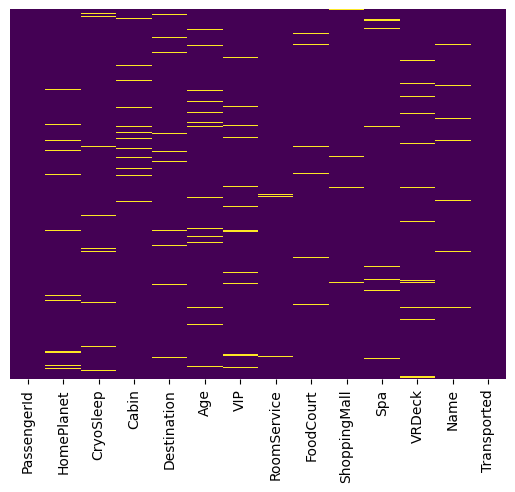

In [10]:
import seaborn as sns

sns.heatmap(train_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

#### Dropping column `Name`

In [11]:
mutated_train_data = train_data.drop(columns=["Name"])
mutated_train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


#### Changing column `Cabin`

In [12]:
mutated_train_data["Cabin"] = mutated_train_data["Cabin"].str.split('/').str[2]
mutated_train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,False,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,Europa,False,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,Europa,False,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,Earth,False,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


#### Preparing functions for replacing missing data with approximate data, based on similarity across other parameters

In [13]:
import math
import random

def get_approximate_missing_value(row: pd.core.series.Series,
                                              df: pd.core.frame.DataFrame,
                                              feature_to_skip: str):
  def is_in_range(number, target, range_val):
    range_val = range_val if range_val > 0 else 5
    if isinstance(number, pd.Series):
      return (number >= (target - range_val)) & (number <= (target + range_val))
    else:
      return (target - range_val) <= number <= (target + range_val)

  def is_not_nan(value):
    if isinstance(value, (int, float)):
      # Use math.isnan for scalar values
      return not math.isnan(value)
    else:
      # If it's not a float or int, it cannot be NaN
      return True

  def get_similar_rows():
    if condition_list:
      combined_condition = condition_list[0]
      for condition in condition_list[1:]:
        combined_condition &= condition
      return df.loc[combined_condition]
    else:
      return df

  HomePlanet, CryoSleep, Cabin, Destination, Age, \
  RoomService, FoodCourt, ShoppingMall, Spa, VRDeck = row['HomePlanet'], row['CryoSleep'], row['Cabin'], row['Destination'], row['Age'], \
                                                      row['RoomService'], row['FoodCourt'], row['ShoppingMall'], row['Spa'], row['VRDeck']

  # Construct conditions
  condition_list = []
  condition_list.append(df['PassengerId'] != row['PassengerId'])
  condition_list.append(df['HomePlanet'] == HomePlanet) if (feature_to_skip != 'HomePlanet' and is_not_nan(HomePlanet)) else condition_list.append(df['HomePlanet'].notnull())
  condition_list.append(df['CryoSleep'] == CryoSleep) if (feature_to_skip != 'CryoSleep' and is_not_nan(CryoSleep)) else condition_list.append(df['CryoSleep'].notnull())
  condition_list.append(df['Cabin'] == Cabin) if (feature_to_skip != 'Cabin' and is_not_nan(Cabin)) else condition_list.append(df['Cabin'].notnull())
  condition_list.append(df['Destination'] == Destination) if (feature_to_skip != 'Destination' and is_not_nan(Destination)) else condition_list.append(df['Destination'].notnull())
  condition_list.append(is_in_range(df['Age'], Age, 5)) if (feature_to_skip != 'Age' and is_not_nan(Age)) else condition_list.append(df['Age'].notnull())
  condition_list.append(is_in_range(df['RoomService'], RoomService, RoomService*0.20)) if (feature_to_skip != 'RoomService' and is_not_nan(RoomService)) else condition_list.append(df['RoomService'].notnull())
  condition_list.append(is_in_range(df['FoodCourt'], FoodCourt, FoodCourt*0.20)) if (feature_to_skip != 'FoodCourt' and is_not_nan(FoodCourt)) else condition_list.append(df['FoodCourt'].notnull())
  condition_list.append(is_in_range(df['ShoppingMall'], ShoppingMall, ShoppingMall*0.20)) if (feature_to_skip != 'ShoppingMall' and is_not_nan(ShoppingMall)) else condition_list.append(df['ShoppingMall'].notnull())
  condition_list.append(is_in_range(df['Spa'], Spa, Spa*0.20)) if (feature_to_skip != 'Spa' and is_not_nan(Spa)) else condition_list.append(df['Spa'].notnull())
  condition_list.append(is_in_range(df['VRDeck'], VRDeck, VRDeck*0.20)) if (feature_to_skip != 'VRDeck' and is_not_nan(VRDeck)) else condition_list.append(df['VRDeck'].notnull())

  similar_rows = []
  # Combine conditions using logical AND
  while(len(similar_rows) == 0):
    res = get_similar_rows()
    similar_rows = res if len(res) > 0 else []
    if len(condition_list) > 0:
      del(condition_list[random.randrange(len(condition_list))])
    else:
      condition_list = None

  # Compute averages for numerical columns
  numerical_columns = similar_rows[["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]]
  numerical_means = numerical_columns.mean()

  # Compute mode for string columns
  string_columns = similar_rows[["HomePlanet", "Cabin", "Destination"]]
  string_modes = string_columns.mode().iloc[0]

  # Compute mode for boolean columns
  if 'Transported' in similar_rows.keys():
    bool_columns = similar_rows[["CryoSleep", "VIP", "Transported"]]
  else:
    bool_columns = similar_rows[["CryoSleep", "VIP"]]
  bool_modes = bool_columns.mode().iloc[0]

  # Create a DataFrame row with the results
  result_row = pd.DataFrame({
      'PassengerId': [None],  # Not applicable for average or mode
      'HomePlanet': [string_modes['HomePlanet']],
      'CryoSleep': [bool_modes['CryoSleep']],
      'Cabin': [string_modes['Cabin']],
      'Destination': [string_modes['Destination']],
      'Age': [numerical_means['Age']],
      'VIP': [bool_modes['VIP']],
      'RoomService': [numerical_means['RoomService']],
      'FoodCourt': [numerical_means['FoodCourt']],
      'ShoppingMall': [numerical_means['ShoppingMall']],
      'Spa': [numerical_means['Spa']],
      'VRDeck': [numerical_means['VRDeck']],
  })
  if 'Transported' in similar_rows.keys():
    result_row['Transported'] = bool_modes['Transported']

  return similar_rows, result_row[feature_to_skip]


df, feature_pred = get_approximate_missing_value(mutated_train_data.iloc[6506], mutated_train_data, 'ShoppingMall')

# print('Our row:\n', mutated_train_data.iloc[6506], '\n\n')
# print('Similar rows:\n', df)

# print('What "missing" feature we want to replace? -', 'ShoppingMall')
# print('What is the prediction of the statistical approch? -', feature_pred[0])
# print('And the right answer is:', mutated_train_data.iloc[6506]["ShoppingMall"])

In [14]:
def fill_missing_values(df: pd.DataFrame):
  # Create a copy of the DataFrame to avoid modifying the original
  df_filled = df.copy()

  # Iterate over the rows of the DataFrame
  for index, row in df.iterrows():
    # Identify columns with NaN values
    nan_columns = row[row.isna()].index

    # Get approximate values for each NaN column
    for feature in nan_columns:
      if feature != 'PassengerId':  # Skip 'PassengerId'
        _, approx_value = get_approximate_missing_value(row, df, feature)

        # Replace NaN with the approximate value
        df_filled.at[index, feature] = approx_value.values[0]

  return df_filled

#### Counting rows with more than one `NaN`

In [15]:
mutated_test_data = test_data.drop(columns=["Name"])

# Create a boolean DataFrame where True indicates NaN
nan_mask_train = mutated_train_data.isna()
nan_mask_test = mutated_test_data.isna()

# Count NaNs in each row
nan_counts_train = nan_mask_train.sum(axis=1)
nan_counts_test = nan_mask_test.sum(axis=1)

print('Train data:')
print("How many NaNs can appear in a single row:", set(nan_counts_train))
print("Number of rows with one NaN:", (nan_counts_train == 1).sum())
print("Number of rows with two NaNs:", (nan_counts_train == 2).sum())
print("Number of rows with three NaNs:", (nan_counts_train == 3).sum())
print('\nTest data:')
print("How many NaNs can appear in a single row:", set(nan_counts_test))
print("Number of rows with one NaN:", (nan_counts_test == 1).sum())
print("Number of rows with two NaNs:", (nan_counts_test == 2).sum())
print("Number of rows with three NaNs:", (nan_counts_test == 3).sum())

Train data:
How many NaNs can appear in a single row: {0, 1, 2, 3}
Number of rows with one NaN: 1746
Number of rows with two NaNs: 171
Number of rows with three NaNs: 12

Test data:
How many NaNs can appear in a single row: {0, 1, 2, 3}
Number of rows with one NaN: 823
Number of rows with two NaNs: 97
Number of rows with three NaNs: 2


#### Applying functions to fill up the DataFrame

In [16]:
while(mutated_train_data.isna().any().any()):
  mutated_train_data = fill_missing_values(mutated_train_data)
mutated_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   object 
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 823.6+ KB


#### Making pipeline structure

 * Remake `HomePlanet` and `Destination` with OneHotEncoder
 * Chage `CryoSleep`, `VIP` and `Transported` to numeric type (int32)
 * Check for `NaN` and incorrect values
 * Add column `Total` for `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa` and `VRDeck`

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X = X.copy()
    encoder = OneHotEncoder()

    # Replacing 'HomePlanet' column with 3 different columns for each planet
    matrix = encoder.fit_transform(X[["HomePlanet"]]).toarray()
    column_names = list(set(mutated_train_data['HomePlanet']))
    for i in range(len(matrix.T)):
      X[column_names[i]] = matrix.T[i]

    # Replacing 'Destination' column with 3 different columns for each planet
    matrix = encoder.fit_transform(X[["Destination"]]).toarray()
    column_names = list(set(mutated_train_data['Destination']))
    for i in range(len(matrix.T)):
      X[column_names[i]] = matrix.T[i]

    # Replacing 'Cabin' column with 2 different columns for each cabin
    matrix = encoder.fit_transform(X[["Cabin"]]).toarray()
    column_names = list(set(mutated_train_data['Cabin']))
    for i in range(len(matrix.T)):
      X[column_names[i]] = matrix.T[i]

    return X.drop(["HomePlanet", "Destination", "Cabin"], axis=1)


class IdTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X = X.copy()
    X["PassengerId"] = X['PassengerId'].str.split('_').str[0]
    return X


class BinaryTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X = X.copy()
    if 'Transported' in X.keys():
      X['CryoSleep'], X['VIP'], X['Transported'] = X['CryoSleep'].astype(int), X['VIP'].astype(int), X['Transported'].astype(int)
    else:
      X['CryoSleep'], X['VIP'] = X['CryoSleep'].astype(int), X['VIP'].astype(int)

    return X


class TotalConnector(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X = X.copy()
    X["Total"] = X["RoomService"] + X["FoodCourt"] + X["ShoppingMall"] + X["Spa"] + X["VRDeck"]
    return X


class ColumnRearranger(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    new_order = ['PassengerId', 'Age', 'VIP', 'CryoSleep', 'P', 'S', 'Earth', 'Mars', 'Europa', '55 Cancri e', 'PSO J318.5-22',
                 'TRAPPIST-1e', 'Total', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported']
    if 'Transported' not in X.keys():
      del(new_order[-1])

    return X[new_order]

In [18]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("feature_encoder", FeatureEncoder()),
    ("id_transformer", IdTransformer()),
    ("binary_transformer", BinaryTransformer()),
    ("total_connector", TotalConnector()),
    ("column_rearranger", ColumnRearranger())
])

In [19]:
train_data_final = pipe.fit_transform(mutated_train_data)
train_data_final

,PassengerId,Age,VIP,CryoSleep,P,S,Earth,Mars,Europa,55 Cancri e,PSO J318.5-22,TRAPPIST-1e,Total,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001,39.0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0002,24.0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,736.0,109.0,9.0,25.0,549.0,44.0,1
2,0003,58.0,1,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,10383.0,43.0,3576.0,0.0,6715.0,49.0,0
3,0003,33.0,0,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,5176.0,0.0,1283.0,371.0,3329.0,193.0,0
4,0004,16.0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1091.0,303.0,70.0,151.0,565.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276,41.0,1,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,8536.0,0.0,6819.0,0.0,1643.0,74.0,0
8689,9278,18.0,0,1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8690,9279,26.0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1873.0,0.0,0.0,1872.0,1.0,0.0,1
8691,9280,32.0,0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,4637.0,0.0,1049.0,0.0,353.0,3235.0,0


### Turn data into tensors and create train and test splits

#### Selecting needed fatures

In [20]:
train_features = train_data_final.drop(columns=['PassengerId', 'Transported'])
train_labels = train_data_final['Transported']
train_features[:5], train_labels[:5]

(    Age  VIP  CryoSleep    P    S  Earth  Mars  Europa  55 Cancri e  \
 0  39.0    0          0  1.0  0.0    1.0   0.0     0.0          0.0   
 1  24.0    0          0  0.0  1.0    0.0   0.0     1.0          0.0   
 2  58.0    1          0  0.0  1.0    1.0   0.0     0.0          0.0   
 3  33.0    0          0  0.0  1.0    1.0   0.0     0.0          0.0   
 4  16.0    0          0  0.0  1.0    0.0   0.0     1.0          0.0   
 
    PSO J318.5-22  TRAPPIST-1e    Total  RoomService  FoodCourt  ShoppingMall  \
 0            1.0          0.0      0.0          0.0        0.0           0.0   
 1            1.0          0.0    736.0        109.0        9.0          25.0   
 2            1.0          0.0  10383.0         43.0     3576.0           0.0   
 3            1.0          0.0   5176.0          0.0     1283.0         371.0   
 4            1.0          0.0   1091.0        303.0       70.0         151.0   
 
       Spa  VRDeck  
 0     0.0     0.0  
 1   549.0    44.0  
 2  6715.0    4

In [21]:
types = train_features.keys()
types

Index(['Age', 'VIP', 'CryoSleep', 'P', 'S', 'Earth', 'Mars', 'Europa',
       '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', 'Total', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
      dtype='object')

#### Convert to tensors

In [22]:
# Convert the DataFrames to numpy arrays
features_array = train_features.to_numpy()
labels_array = train_labels.to_numpy()

# Convert the numpy arrays to torch tensors
X = torch.tensor(features_array, dtype=torch.float32)
y = torch.tensor(labels_array, dtype=torch.float32)

In [23]:
X[0], y[0], X[0].shape, y[0].shape

(tensor([39.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.]),
 tensor(0.),
 torch.Size([17]),
 torch.Size([]))

#### Split data into train and test splits

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [25]:
len(X_train), len(X_test), len(y_train), len(y_test)

(6954, 1739, 6954, 1739)

### Building a model

In [26]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [27]:
from torch import nn
# 1. Construct a model that subclasses nn.Module
class Model(nn.Module):
  def __init__(self, in_shape: int, out_shape: int, hidden_layers: int):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=in_shape, out_features=hidden_layers)
    self.layer_2 = nn.Linear(in_features=hidden_layers, out_features=out_shape)

  # 3. Define forward() method that outlines the forward pass
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and sent it ti the target device
model = Model(in_shape=len(types),
              out_shape=1,
              hidden_layers=25).to(device)
model

Model(
  (layer_1): Linear(in_features=17, out_features=25, bias=True)
  (layer_2): Linear(in_features=25, out_features=1, bias=True)
)

### Setting up loss function, optimizer and accuracy function

In [28]:
# Setup loss function and optimizer
from torch.optim.lr_scheduler import StepLR

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10000, gamma=0.1)  # Reduce LR every 1000 epochs by a factor of 0.1

In [29]:
# Accuracy calculaton func
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

### Training and Testing loop

In [30]:
X_test, y_test = X, y

In [31]:
# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)

epochs = 10000
for epoch in range(epochs):
  model.train()

  # 1. Forward pass
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  # ### Testing
  # model.eval()
  # with torch.inference_mode():
  #   # 1. forward pass
  #   test_logits = model(X_test).squeeze()
  #   test_pred = torch.round(torch.sigmoid(test_logits))

  #   # 2. calculate loss/accuracy
  #   test_loss = loss_fn(test_pred, y_test)
  #   test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print out
  if epoch % 1000 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Train accuracy: {acc:.2f}%") #  | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%

Epoch: 0 | Train loss: 23.67566 | Train accuracy: 72.94%
Epoch: 1000 | Train loss: 0.43985 | Train accuracy: 79.71%
Epoch: 2000 | Train loss: 0.45598 | Train accuracy: 79.36%
Epoch: 3000 | Train loss: 0.45564 | Train accuracy: 79.03%
Epoch: 4000 | Train loss: 0.44010 | Train accuracy: 79.65%
Epoch: 5000 | Train loss: 0.43855 | Train accuracy: 79.65%
Epoch: 6000 | Train loss: 0.46488 | Train accuracy: 79.49%
Epoch: 7000 | Train loss: 0.49836 | Train accuracy: 78.37%
Epoch: 8000 | Train loss: 0.75235 | Train accuracy: 75.93%
Epoch: 9000 | Train loss: 0.43858 | Train accuracy: 79.67%


In [32]:
def save_model(model, filepath, save_state_dict=True):
  if save_state_dict:
    torch.save(model.state_dict(), filepath)
  else:
    torch.save(model, filepath)

In [33]:
save_model(model, 'spaceship_model_0.pth', save_state_dict=True)

### Making predictions

In [34]:
mutated_test_data = test_data.drop(columns=["Name"])
mutated_test_data["Cabin"] = mutated_test_data["Cabin"].str.split('/').str[2]

while(mutated_test_data.isna().any().any()):
  mutated_test_data = fill_missing_values(mutated_test_data)

test_data_final = pipe.fit_transform(mutated_test_data)
test_data_final

,PassengerId,Age,VIP,CryoSleep,P,S,Earth,Mars,Europa,55 Cancri e,PSO J318.5-22,TRAPPIST-1e,Total,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0013,27.000000,0,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0018,19.000000,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2832.0,0.0,9.0,0.0,2823.0,0.0
2,0019,31.000000,0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0021,38.000000,0,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,7418.0,0.0,6652.0,0.0,181.0,585.0
4,0023,20.000000,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,645.0,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266,34.000000,0,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4273,9269,42.000000,0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1018.0,0.0,847.0,17.0,10.0,144.0
4274,9271,28.714286,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4275,9273,27.500000,0,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3203.0,0.0,2680.0,0.0,0.0,523.0


In [35]:
test_features = test_data_final.drop(columns=['PassengerId'])

# Convert the DataFrames to numpy arrays
features_array = test_features.to_numpy()

# Convert the numpy arrays to torch tensors
X = torch.tensor(features_array, dtype=torch.float32)

In [36]:
model.eval()
with torch.inference_mode():
  test_logits = model(X.to(device)).squeeze()
  test_pred = torch.round(torch.sigmoid(test_logits))

test_pred.type(torch.bool)

tensor([ True, False,  True,  ...,  True,  True,  True])

In [37]:
output_preds = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Transported': test_pred.cpu().type(torch.bool)})
output_preds.to_csv('spaceship_submission.csv', index=False)